In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn import metrics
# import plots
import seaborn as sns
from datetime import datetime

In [2]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/Research/RECAST/latin-mobility-covid-local-files'

country = 'Mexico'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
elif country == 'Mexico':
    country_short = 'MEX'
    country_code = 'MX'

In [3]:
grid_popcell = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_FB_pop/Grid_' + country + '.shp').to_crs('EPSG:4326')
grid_movcell = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_FB_mov/Grid_' + country + '.shp').to_crs('EPSG:4326')

meters = 0.2*(np.sqrt(grid_popcell.to_crs('EPSG:3857').loc[2500,'geometry'].area))
grid_movcell_buff = gpd.GeoDataFrame({'FID': grid_movcell['FID'], 'geometry': grid_movcell.to_crs('EPSG:3857').buffer(meters).to_crs('EPSG:4326')})


In [4]:
len(grid_movcell)

6741

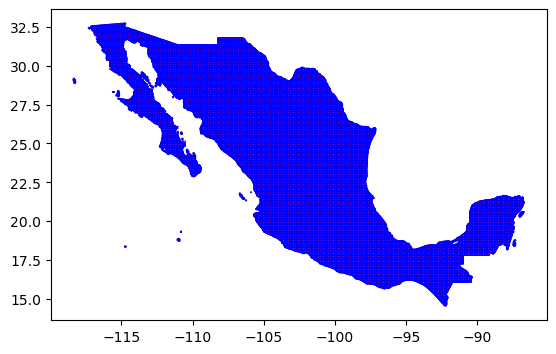

In [5]:
fig, ax = plt.subplots()
grid_popcell.plot(ax=ax, edgecolor='white', facecolor='blue', alpha=0.3, zorder=1)
grid_movcell.plot(ax=ax, edgecolor='red', facecolor='None', alpha=1, zorder=2)
grid_movcell_buff.plot(ax=ax, edgecolor='blue', facecolor='None', alpha=1, zorder=3)
# ax.set_xlim([-105,-104])
# ax.set_ylim([18.5,19.5])
plt.show()

In [6]:
grid_popcell_centroid = grid_popcell.copy()
grid_popcell_centroid['geometry'] = grid_popcell_centroid.to_crs('EPSG:3857').centroid
gdf_sjoin_centroid = gpd.sjoin(grid_movcell.to_crs('EPSG:3857'), grid_popcell_centroid, how='left', predicate='contains_properly', lsuffix='mov', rsuffix='pop').drop(['index_pop'], axis=1)

len(gdf_sjoin_centroid)

25791

In [7]:
gdf_sjoin = gpd.sjoin(grid_movcell_buff, grid_popcell, how='left', predicate='contains', lsuffix='mov', rsuffix='pop').drop(['index_pop'], axis=1)


In [8]:
gdf_sjoin.to_file(wd + '/data/inputs/grids/Grid_' + country + '_lookup_mov_to_pop.gpkg') 

In [9]:
len(gdf_sjoin)

26187

In [10]:
grid_pop_imput_movcell = grid_movcell

for i in range(7):
    grid_pop_imput_movcell[str(i)] = [np.nan for i in range(len(grid_pop_imput_movcell))]

In [11]:
# Sum populations of popcells in grid_pop_imput_popcell according to whichever popcells fall within each movcell
# Imput the data into the grid_pop_imput_movcell

grid_pop_imput_popcell = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/popcell-baseline-imput-pop/popcell-baseline-imput-pop.gpkg')

for i in range(len(grid_pop_imput_movcell)):
    
    FIDs_pop = np.array(gdf_sjoin[gdf_sjoin['FID_mov']==i]['FID_pop'])
    
    gdf_movcell = grid_pop_imput_popcell.iloc[FIDs_pop]
    
    for wday in range(7):
        
        pops_movcell = np.array(gdf_movcell[str(wday)])
        pops_movcell = pops_movcell[~np.isnan(pops_movcell)]
        if len(pops_movcell)>0:
            grid_pop_imput_movcell.loc[i, str(wday)] = np.sum(pops_movcell)
        else:
            grid_pop_imput_movcell.loc[i, str(wday)] = np.nan
        
        

In [12]:
grid_pop_imput_movcell

,FID,geometry,0,1,2,3,4,5,6
0,0,"POLYGON ((-92.28518 14.60483, -92.28518 14.587...",1.789244,1.827987,1.831134,1.829704,1.828568,1.753881,1.675756
1,1,"POLYGON ((-92.28518 14.60483, -92.17801 14.604...",669.430063,679.947759,681.545755,680.510116,680.811923,657.824939,630.175785
2,2,"POLYGON ((-92.46096 14.77487, -92.46096 14.752...",0.422625,0.431776,0.432519,0.432181,0.431913,0.414272,0.395818
3,3,"POLYGON ((-92.46096 14.77487, -92.28518 14.774...",868.734779,884.334930,884.667762,881.517203,878.445324,825.794746,807.050615
4,4,"POLYGON ((-92.28518 14.60483, -92.28518 14.774...",2756.044748,2812.245392,2819.183645,2812.882430,2813.499041,2709.863113,2582.769860
...,...,...,...,...,...,...,...,...,...
6736,6736,"POLYGON ((-114.96094 32.54678, -114.96094 32.6...",2213.420693,2173.341759,2158.707005,2154.075890,2180.429510,2206.628213,2255.840139
6737,6737,"POLYGON ((-114.78516 32.69483, -114.73457 32.6...",67.613561,69.077588,69.196505,69.142469,69.099536,66.277226,63.324962
6738,6738,"POLYGON ((-114.96094 32.69483, -115.05275 32.6...",0.141261,0.144319,0.144568,0.144455,0.144365,0.138469,0.132301
6739,6739,"POLYGON ((-114.78516 32.69483, -114.96094 32.6...",4.979425,5.087244,5.096001,5.092022,5.088860,4.881010,4.663590


<Axes: >

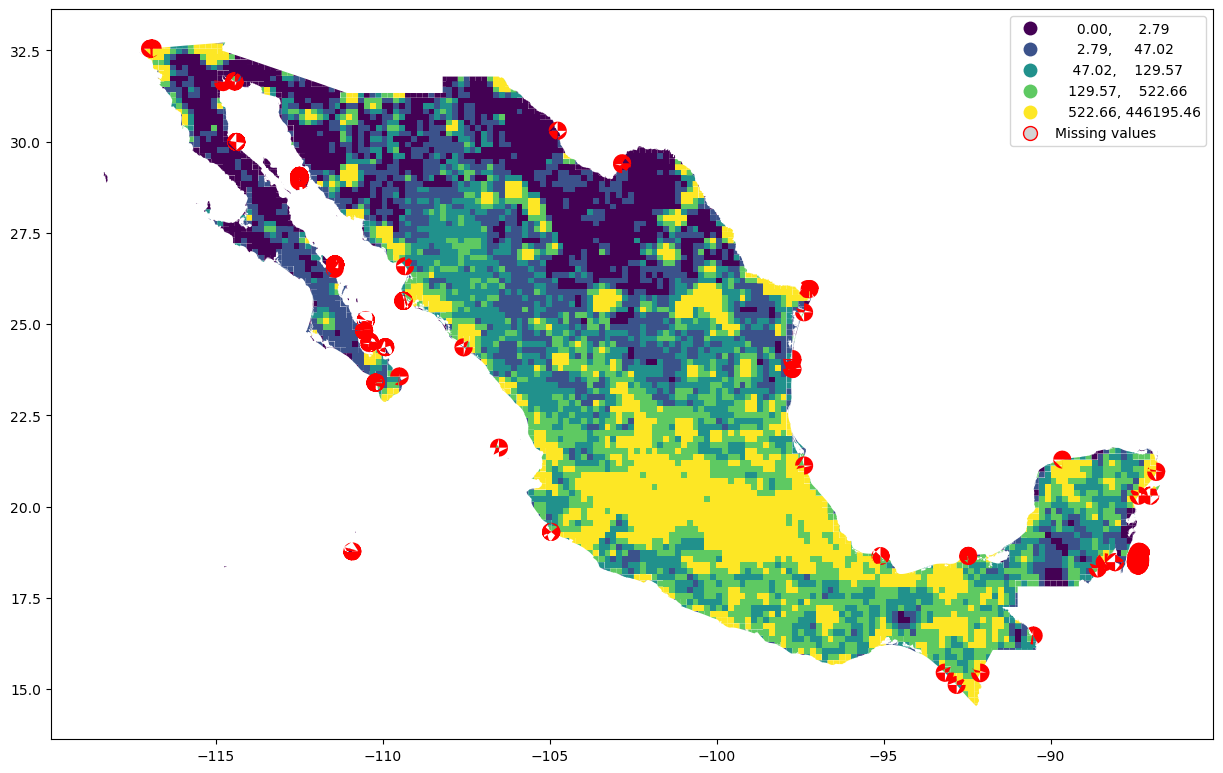

In [13]:
grid_pop_imput_movcell.plot(column='1', legend=True,
    scheme="quantiles",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "lw": 13,
        "hatch": "///",
        "label": "Missing values",
    },
)

In [14]:
grid_pop_imput_movcell.to_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop/movcell-baseline-imput-pop.gpkg')



In [15]:
len(grid_pop_imput_movcell[grid_pop_imput_movcell['0']>0])/len(grid_pop_imput_movcell)

0.9775997626464916

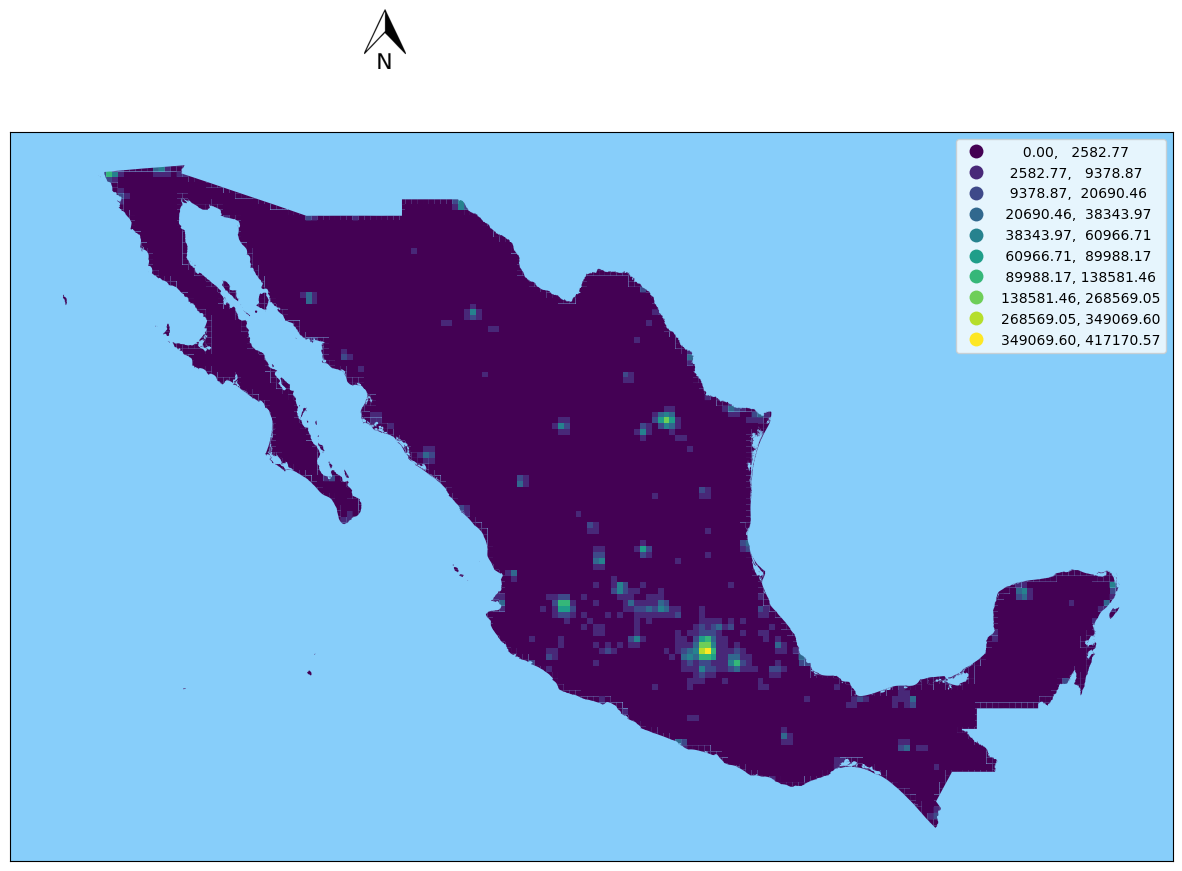

In [16]:
fig, ax = plt.subplots(figsize = (15, 15))

# south_america = gpd.read_file(wd + '/data/inputs/boundaries/south-america/vc965bq8111.shp').to_crs('EPSG:4326')

# south_america.plot(ax=ax, facecolor='dimgray', alpha=0.5, zorder=1)
ax.set_facecolor('lightskyblue')

grid_pop_imput_movcell.plot(column='6', cmap='viridis', scheme='natural_breaks', k=10, legend=True, ax=ax)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelleft=False, labelbottom=False)

# ax.set_xlim(-75,-49)
# ax.set_ylim(-59,-19.5)

labels = [t.get_text() for t in ax.get_legend().get_texts()]

upper = []
for i in range(len(labels)):
    a = labels[i].split(',')[1]
    b=[]
    for e in a:
        if e.isdigit() or e=='.':
            b.append(e)
    upper.append(float(''.join(b)))
upper[-1] = upper[-1]+0.005

custom_labels = ['[0, ' + str(int(upper[0])) + ']']
for i in range(len(upper)-1):
    custom_labels.append('[' + str(int(upper[i])) + ', ' + str(int(upper[i+1])) + ']')

colors=mcp.gen_color(cmap='viridis',n=10)
legend_elements = [Line2D([0], [0], lw=0, color=colors[i],
                          marker='o', markersize=10, label=custom_labels[i]) for i in range(len(colors))]

# legend = ax.legend(handles=legend_elements, handlelength=0, fontsize = 14, shadow=False,
#                    fancybox= False, loc=(0.49,0.08), ncol=1, columnspacing=1.2, 
#                    borderpad=1, title = 'FB population counts \nfor input baseline \n(Monday)')
# for t in legend.get_texts():
#     t.set_ha('right')
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_linewidth(1)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 0.7))
# legend.get_title().set_fontsize('14')

# ax.add_artist(ScaleBar(dx=1,units="km",dimension="si-length",length_fraction=.1, 
#                    scale_formatter=lambda value, unit: f' {value * 100} km ', 
#                    pad=0.7, sep=5, border_pad = 1, scale_loc='top', box_color='w', box_alpha=0, font_properties={'size':20}, location='upper left'))

im = plt.imread(wd + '/data/inputs/boundaries/north-arrow.png')

newax = fig.add_axes([0.355,0.78,0.04,0.04], zorder=1)
newax.tick_params(axis = 'both', which = 'both', labelbottom=False, labelleft=False, width = 0, length = 0)
newax.set_facecolor('None')
plt.setp(newax.spines.values(), linewidth=0)
newax.imshow(im)

plt.show()

In [17]:
len(grid_pop_imput_movcell[grid_pop_imput_movcell['0']>0])/len(grid_pop_imput_movcell)

0.9775997626464916

In [18]:
len(grid_pop_imput_popcell[grid_pop_imput_popcell['0']>0])/len(grid_pop_imput_popcell)

0.9616289383363542